

# Yandex Data Science School
## Linear Regression & Regularization Exercise.


## Outline
In this exercise you will learn the following topics:

1. Refresher on how linear regression is solved in batch and in Gradient Descent 
2. Implementation of Ridge Regression
3. Comparing Ridge, Lasso and vanila Linear Regression on a dataset

## Refresher on Ordinary Least Square (OLS) aka Linear Regeression

### Lecture Note

In Matrix notration, the matrix $X$ is of dimensions $n \times p$ where is each row is an example and each column is a feature dimension. 

Similarily, $y$ is of dimension $n \times 1$ and $w$ is of dimensions $p \times 1$.

The model is $\hat{y}=X\cdot w$ where we assume for simplicity that $X$'s first columns equals to 1 (one padding), to account for the bias term.

Our objective is to optimize the loss $L$ defines as resiudal sum of squares (RSS): 

$L_{RSS}=\frac{1}{N}\left\Vert Xw-y \right\Vert^2$ (notice that in matrix notation this means summing over all examples, so $L$ is scalar.)

To find the optimal $w$ one needs to derive the loss with respect to $w$.

$\frac{\partial{L_{RSS}}}{\partial{w}}=\frac{2}{N}X^T(Xw-y)$ (to see why, read about [matrix derivatives](http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf) or see class notes )

Thus, the gardient descent solution is $w'=w-\alpha \frac{2}{N}X^T(Xw-y)$.

Solving $\frac{\partial{L_{RSS}}}{\partial{w}}=0$ for $w$ one can also get analytical solution:

$w_{OLS}=(X^TX)^{-1}X^Ty$

The first term, $(X^TX)^{-1}X^T$ is also called the pseudo inverse of $X$.

See [lecture note from Stanford](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf) for more details.


## Exercise 1 - Ordinary Least Square
* Get the boston housing dataset by using the scikit-learn package. hint: [load_boston](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)

* What is $p$? what is $n$ in the above notation? hint: [shape](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.shape.html)

* write a model `OrdinaryLinearRegression` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score` (which returns the MSE on a given sample set). Hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.

* Fit the model. What is the training MSE?

* Plot a scatter plot where on x-axis plot $Y$ and in the y-axis $\hat{Y}_{OLS}$

* Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test? Hint: use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) or [ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html).

* Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value? Hint: use [scipy.stats.ttest_rel](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html). 

* Write a new class `OrdinaryLinearRegressionGradientDescent` which inherits from `OrdinaryLinearRegression` and solves the problem using gradinet descent. The class should get as a parameter the learning rate and number of iteration. Plot the class convergance. What is the effect of learning rate? How would you find number of iteration automatically? Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your features first.

* **Bonus:** Repeat for coordinate descent by creating a new class `OrdinaryLinearRegressionCoordinateDescent` which also inherits from `OrdinaryLinearRegression`. Compare the learning curves.


In [1]:
# * write a model `Ols` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score`.?
# hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html)
# to be more efficient.
import numpy as np

class Ols(object):
    def __init__(self):
        self.w = None
    
    @staticmethod
    def pad(X):
        return np.insert(X, 0, 1, axis=1)
  
    def fit(self, X, Y):
        #remeber pad with 1 before fitting
        X = self.pad(X)
        X_cross = np.matmul(np.linalg.pinv(np.matmul(X.T, X)), X.T)
        self.w = np.matmul(X_cross, Y)
        return self.w
  
    def predict_row(self,x):
        return np.dot(self.w.T, x)
    
    def predict(self, X):
        #return wx
        wx = np.zeros(X.shape[0])
        X = self.pad(X)
        
        for i, x in enumerate(X):
            wx[i] = self.predict_row(x)
        
        return wx
    
    #  returns the MSE on a given sample set
    def score(self, X, Y):
        y_hat = self.predict(X)
        MSE = np.square(np.subtract(Y,y_hat)).mean()
        return MSE

In [2]:
# Write a new class OlsGd which solves the problem using gradinet descent. 
# The class should get as a parameter the learning rate and number of iteration. 
# Plot the loss convergance. for each alpha, learning rate plot the MSE with respect to number of iterations.
# What is the effect of learning rate? 
# How would you find number of iteration automatically? 
# Note: Gradient Descent does not work well when features are not scaled evenly (why?!).
# Be sure to normalize your feature first.
class Normalizer():
    def __init__(self):
        pass
    
    # fit data mu and sigma will be used for normalizing
    def fit(self, X):
        self.mu = np.mean(X, axis = 0)
        self.sigma = np.std(X, axis= 0, ddof = 1)
        X_norm = (X - self.mu)/self.sigma
        return X_norm

    def predict(self, X):
        #apply normalization
        X_norm = (X - self.mu)/self.sigma
        return X_norm
    
class OlsGd(Ols):
  
    def __init__(self, learning_rate=.05, 
                num_iteration=1000, 
                normalize=True,
                early_stop=True,
                verbose=True):
    
        super(OlsGd, self).__init__()
        self.learning_rate = learning_rate
        self.num_iteration = num_iteration
        self.early_stop = early_stop
        self.normalize = normalize
        self.normalizer = Normalizer()    
        self.verbose = verbose
        self.delta = 0.000000001
    
    def fit(self, X, Y, reset=True, track_loss=True):
        #remeber to normalize the data before starting
        if self.normalize:
            self.normalizer.fit(X)
            X = self.normalizer.predict(X)

        X = self.pad(X)
        self.n = X.shape[1]
        self.m = len(Y)
        self.w = np.zeros(self.n) 
        self.costs = []
        self.costs.append(np.inf)
        self.finish = False
        
        for i in range(self.num_iteration): 
            
            if self.finish:
                break
            
            self._step(X, Y)
            
            # print iteration number and loss
            if self.verbose and (i+1) % 200 == 0:
                print("Cost at iteration {0}: {1}".format(i+1,self.costs[-1]))
        
        self.costs.pop(0)     
        return self
        
    def predict(self, X):
        #remeber to normalize the data before starting
        if self.normalize:
            X = self.normalizer.predict(X)
        
        X = self.pad(X)
        return np.dot(X,self.w)
      
    def _step(self, X, Y):
        # use w update for gradient descent
        Y_pred = np.dot(X,self.w)
        cost = np.sum(((Y_pred-Y) ** 2)) / (2 * self.m)
        self.costs.append(cost)
        
        # stop running when loss stops decaying
        if self.early_stop and (self.costs[-2] - self.costs[-1] < self.delta):
            self.finish = True
        
        # Un-normalized data would warp this part
        else:
            self.w = self.w - (1/self.m) * self.learning_rate * (X.T.dot(Y_pred - Y))
            
        return self

In [3]:
# Bonus: Repeat for coordinate descent by creating a new class OrdinaryLinearRegressionCoordinateDescent which also inherits
# from OrdinaryLinearRegression

class OlsCd(Ols):
    """coordinate descent"""
  
    def __init__(self, 
                num_iteration=10, 
                verbose=True):
        super(OlsCd, self).__init__()
        self.num_iteration = num_iteration
        self.verbose = verbose
        self.loss = []
        self.normalize = True
        self.normalizer = Normalizer()
    
    def fit(self, X, Y, reset=True, track_loss=True):
        self.normalizer.fit(X)
        X = self.normalizer.predict(X)  # for easy convergence
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        self.m, self.n = X.shape
        self.loss.append(np.inf)
        
        if reset:
            self.w = np.zeros(self.n)
        
        for iteration in range(self.num_iteration):
            self._step(X,Y)
            
            # print iteration number and loss
            if self.verbose and (iteration+1) % 2 == 0:
                print("Cost at iteration {0}: {1}".format(iteration+1,self.loss[-1]))
        
        self.loss.pop(0)
        return self
                
    def _step(self, X, Y):
        #Coordinate gradient descent step
        Y_pred = X.dot(self.w)
        cost = np.sum(((Y_pred-Y) ** 2)) / (2 * len(Y))
        self.loss.append(cost)
       
        for i in range(len(self.w)):
            without_i = np.dot(np.delete(X, i, axis=1), np.delete(self.w, i, axis=0))
            self.w[i] = np.dot(X[:,i].T, (Y.ravel() - without_i))/np.sum(np.square(X[:,i]))
    
    def predict(self, X):
        X = self.normalizer.predict(X) 
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        return X.dot(self.w)

In [4]:
# Get the boston housing dataset

from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)

In [5]:
# What is 𝑝 ? what is 𝑛 in the above notation?

print("p is", X.shape[1])
print("n is", X.shape[0])

p is 13
n is 506


In [6]:
# Fit the model. What is the training MSE?

our_ols = Ols()
our_ols.fit(X,y)
MSE = our_ols.score(X,y) 
print("The training MSE is",MSE)

The training MSE is 21.894831181729202


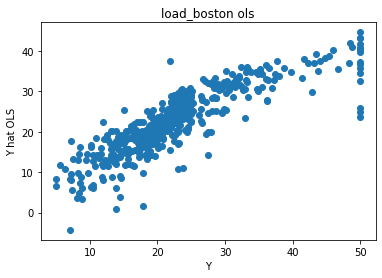

In [7]:
# Plot a scatter plot where on x-axis plot 𝑌 and in the y-axis 𝑌̂ 𝑂𝐿𝑆

import matplotlib.pyplot as plt

y_pred = our_ols.predict(X)
plt.scatter(y,y_pred)
plt.title("load_boston ols")
plt.xlabel("Y")
plt.ylabel("Y hat OLS")
plt.show()

In [8]:
# Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test?

from sklearn.model_selection import train_test_split
np.random.seed(42)

train_mses = np.zeros(20)
test_mses = np.zeros(20)

for i in range (20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    loop_ols = Ols()
    loop_ols.fit(X_train,y_train)
    train_mses[i] = loop_ols.score(X_train,y_train)
    test_mses[i] = loop_ols.score(X_test,y_test)

avg_train_mse = np.mean(train_mses)
avg_test_mse = np.mean(test_mses)
print("Average train MSE is", avg_train_mse)
print("Average test MSE is", avg_test_mse)

Average train MSE is 21.193933513766574
Average test MSE is 25.507532313870357


In [9]:
# Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value?

from scipy import stats

t, prob = stats.ttest_rel(train_mses,test_mses)
p = prob / 2
print("p-value is",p)

if(p < 0.05):
    print("MSE for training is significantly smaller than for testing.")
else:
    print("MSE for training is not significantly smaller than for testing.")

p-value is 0.015723964825927084
MSE for training is significantly smaller than for testing.


2000 iterations for 0.01 learning rate
2000 iterations for 0.02 learning rate
2000 iterations for 0.03 learning rate
2000 iterations for 0.04 learning rate
2000 iterations for 0.05 learning rate
2000 iterations for 0.06 learning rate
1786 iterations for 0.07 learning rate
1576 iterations for 0.08 learning rate
1412 iterations for 0.09 learning rate
1279 iterations for 0.1 learning rate


Text(0.5, 1.0, 'OlsGd convergance')

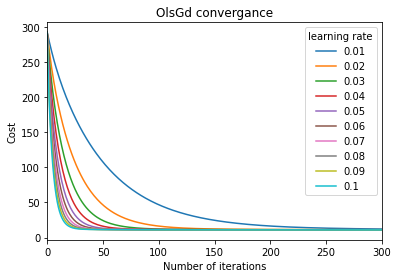

In [10]:
# Plot the OlsGd class convergance.

axes = plt.gca()
axes.set_xlim(0,300)

for i in np.arange(0.01, 0.11, 0.01):
    regr = OlsGd(num_iteration=2000,learning_rate=i,verbose=False,early_stop=True)
    regr.fit(X_train, y_train)
    plt.plot(regr.costs,label=round(i,2))
    print(f"{len(regr.costs)} iterations for {round(i,2)} learning rate")

plt.legend(title="learning rate")
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.title("OlsGd convergance")

####  What is the effect of learning rate? How would you find number of iteration automatically? ####
To find number of iteration automatically we can fit the model with the early_stop parameter and get the last position of the costs list the model provides (as we printed in the cell above).

As we increase the learning rate the convergance takes less iterations. However we need to be carefull and not set it too high and cause drastic updates which lead to divergent behaviors. As we can see in the next cell:

Text(0.5, 1.0, 'OlsGd fails to converge with 0.4 learning rate')

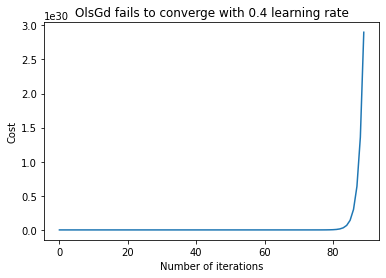

In [11]:
axes = plt.gca()
regr_high = OlsGd(num_iteration=90,learning_rate=0.4,verbose=True,early_stop=False)
regr_high.fit(X_train, y_train)
plt.plot(regr_high.costs)
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.title("OlsGd fails to converge with 0.4 learning rate")

Text(0.5, 1.0, 'Models convergance. Fit on train and predict test')

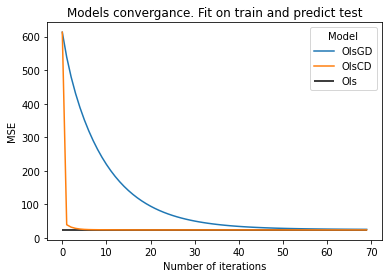

In [12]:
# On the test data for each of the methods Ols, OlsGD, and OlsCD plot the MSE with respect to the iterations

axes = plt.gca()
Gd_scores = []
Cd_scores = []
regOLS = Ols()
regOLS.fit(X_train, y_train)
predOls = regOLS.predict(X_test)
olsScore = np.square(np.subtract(y_test,predOls)).mean()

for i in np.arange(0,70,1):
    regGd = OlsGd(num_iteration=i,verbose=False)
    regGd.fit(X_train, y_train)
    Gd_scores.append(regGd.score(X_test,y_test))
    regCd = OlsCd(num_iteration=i,verbose=False)
    regCd.fit(X_train, y_train)
    Cd_scores.append(regCd.score(X_test,y_test))

plt.plot(range(0,70,1),Gd_scores,label="OlsGD")
plt.hlines(olsScore,0,69,label="Ols")
plt.plot(range(0,70,1),Cd_scores,label="OlsCD")
plt.legend(title="Model")
plt.xlabel("Number of iterations")
plt.ylabel("MSE")
plt.title("Models convergance. Fit on train and predict test")

## Exercise 2 - Ridge Linear Regression

Recall that ridge regression is identical to OLS but with a L2 penalty over the weights:

$L(y,\hat{y})=\frac{1}{N}\sum_{i=1}^{i=N}{(y^{(i)}-\hat{y}^{(i)})^2} + \lambda \left\Vert w \right\Vert_2$

* Show, by differentiating the above loss, that the analytical solution is $w_{Ridge}=(X^TX+\lambda I)^{-1}X^Ty$
* Change `OrdinaryLinearRegression` and `OrdinaryLinearRegressionGradientDescent` classes to work also for ridge regression (do not use the random noise analogy but use the analytical derivation). Either add a parameter, or use inheritance.
* **Bonus: Noise as a regularizer**: Show that OLS (ordinary least square), if one adds multiplicative noise to the features the **average** solution for $W$ is equivalent to Ridge regression. In other words, if $X'= X*G$ where $G$ is an uncorrelated noise with variance $\sigma$ and mean 1, then solving for $X'$ with OLS is like solving Ridge for $X$. What is the interpretation? 



#### Show, by differentiating the above loss, that the analytical solution is  𝑤𝑅𝑖𝑑𝑔𝑒=(𝑋𝑇𝑋+𝜆𝐼)−1𝑋𝑇𝑦 ####

![image-7.png](attachment:image-7.png)

In [13]:
# Change OrdinaryLinearRegression and OrdinaryLinearRegressionGradientDescent classes to work also for ridge regression

class RidgeLs(Ols):
    def __init__(self, ridge_lambda, *wargs, **kwargs):
        super(RidgeLs,self).__init__(*wargs, **kwargs)
        self.ridge_lambda = ridge_lambda
    
    def fit(self, X, Y):
        #Closed form of ridge regression
        X = self.pad(X)
        I = np.identity(X.shape[1])
        self.w = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X) + self.ridge_lambda * I), X.T), Y)
        return self.w
    
class RidgeGd(OlsGd):
    def __init__(self, ridge_lambda, *wargs, **kwargs):
        super(RidgeGd,self).__init__(*wargs, **kwargs)
        self.ridge_lambda = ridge_lambda
    
    
    def _step(self, X, Y):
        # use w update for gradient descent
        Y_pred = np.dot(X,self.w)
        cost = np.sum(((Y_pred-Y) ** 2)) / (2 * self.m)
        self.costs.append(cost)
        
        # stop running when loss stops decaying
        if self.early_stop and (self.costs[-2] - self.costs[-1] < self.delta):
            self.finish = True
        
        # Un-normalized data would warp this part
        else:
            self.w = self.w - self.learning_rate * (1/self.m)* ((X.T @ (Y_pred-Y)) + self.ridge_lambda * self.w)
            
        return self

In [14]:
# Check ridge classes performance

min_ls_mse = np.inf
min_gd_mse = np.inf
min_ls_lam = 0
min_gd_lam = 0
min_ls_mse_tr = np.inf
min_gd_mse_tr = np.inf
min_ls_lam_tr = 0
min_gd_lam_tr = 0

for i in np.arange(0.01, 1.01, 0.01):
    ls_train_list = []
    ls_test_list = []
    gd_train_list = []
    gd_test_list = []
    
    for k in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        loop_ridgels = RidgeLs(ridge_lambda=i)
        loop_ridgegd = RidgeGd(ridge_lambda=i,verbose=False)
        loop_ridgels.fit(X_train,y_train)
        loop_ridgegd.fit(X_train,y_train)
        ls_test_list.append(loop_ridgels.score(X_test,y_test))
        gd_test_list.append(loop_ridgegd.score(X_test,y_test))
        ls_train_list.append(loop_ridgels.score(X_train,y_train))
        gd_train_list.append(loop_ridgegd.score(X_train,y_train))
    
    if (np.mean(ls_test_list) < min_ls_mse):
        min_ls_mse = np.mean(ls_test_list)
        min_ls_lam = i
        
    if (np.mean(gd_test_list) < min_gd_mse):
        min_gd_mse = np.mean(gd_test_list)
        min_gd_lam = i
         
    if (np.mean(ls_train_list) < min_ls_mse_tr):
        min_ls_mse_tr = np.mean(ls_train_list)
        min_ls_lam_tr = i
        
    if (np.mean(gd_train_list) < min_gd_mse_tr):
        min_gd_mse_tr = np.mean(gd_train_list)
        min_gd_lam_tr = i

print(f"Best average RidgeLs train MSE is {min_ls_mse_tr} with lambda {min_ls_lam_tr}")
print(f"Best average RidgeLs test MSE is {min_ls_mse} with lambda {min_ls_lam}")
print(f"Best average RidgeGd train MSE is {min_gd_mse_tr} with lambda {min_gd_lam_tr}")
print(f"Best average RidgeGd test MSE is {min_gd_mse} with lambda {min_gd_lam}")

Best average RidgeLs train MSE is 20.727344832902922 with lambda 0.34
Best average RidgeLs test MSE is 20.625057969464216 with lambda 0.21000000000000002
Best average RidgeGd train MSE is 20.44885838003045 with lambda 0.34
Best average RidgeGd test MSE is 20.621777940284737 with lambda 0.3


#### Bonus: Noise as a regularizer: ####
![image-10.png](attachment:image-10.png)
![image-11.png](attachment:image-11.png)
So in expectation, adding noise to OLS is equivalent to Ridge regression.

## Exercise 3 - Lasso Linear Regression

As we've seen in class, Lasso Regression is a regularization technique with $L_1$ penalty on weights. This techniques creates sparse weights (some weights become effectively zero). Programming a Lasso solver is a challange and is left as an optional exercise below.
This exercise will focus on the analysis of the different regularization techniques over a toy problem using the scikit-learn implementation.

### Data generation: 1-D Polynomal Regression
```
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
degrees = [1, 4, 15]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

```

* Use the preprocessing transformer `sklearn.preprocessing.PolynomialFeatures` in order to create a feature space. Note, you can use `sklearn.pipeline.Pipeline` in order to create an effective model which does the preprocessing (not essential).
* Use `sklearn.model_selection.cross_val_score` to evaluate each of the linear model provided by Scikit-learn (`from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV`) and compare the performance over the different `degrees`. To do so, create a 3x3 plot where each row correspond to one model and each column to one degree. Each plot should plot the train data as well as the true model and the fitted one (use 100 points in the range [0,1]) and the CV (cross validation) MSE. What is the take home message? (Note: RidgeCV and LassoCV do an internal cross-validation to determin the regularization parameter.)
* Weights spectrum: change the `alpha` parameter gradually (on a logartithmic scale) and observe how the coefficients change for `degrees=5` over alpha for Ridge and Lasso. What is the take home message?

In [15]:
#Use scikitlearn implementation for OLS, Ridge and Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
import itertools
plt.style.use('seaborn')

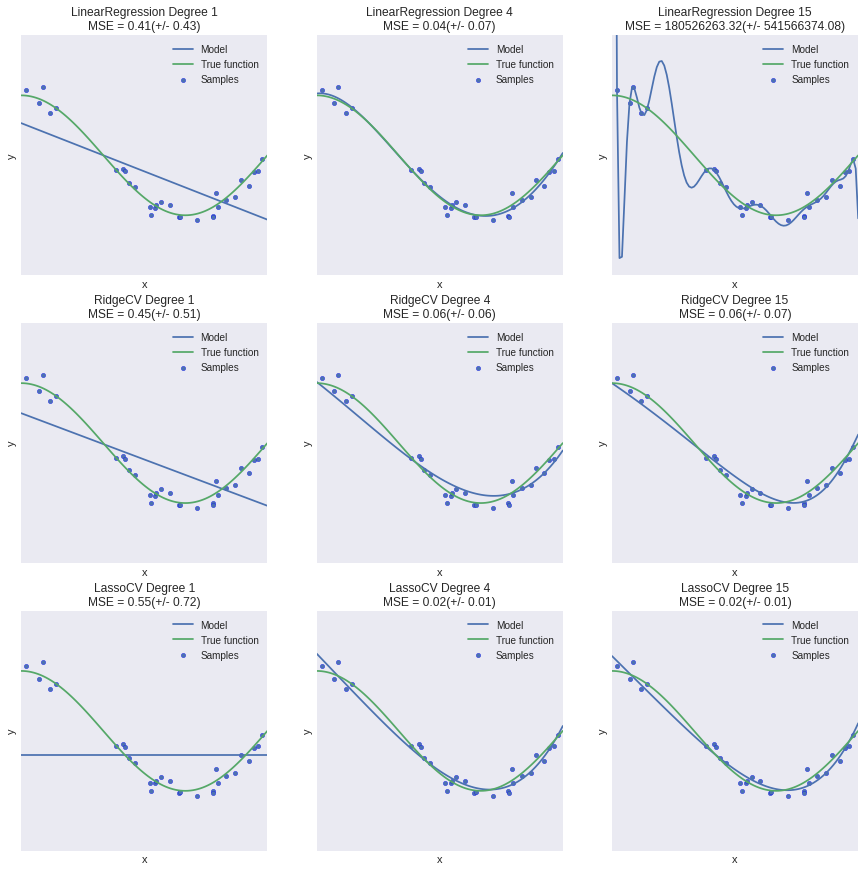

In [16]:
# Use sklearn.model_selection.cross_val_score to evaluate each of the linear model provided by Scikit-learn (from
# sklearn.linear_model import LinearRegression, RidgeCV, LassoCV) and compare the performance over the different degrees

def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

# we use small amaunt of samples to show what happens when there are many dimensions but not enough examples
n_samples = 30
degrees = [1, 4, 15]
models = ['LinearRegression', 'RidgeCV', 'LassoCV']
dict_models = {
    "LinearRegression": LinearRegression(),
    "RidgeCV": RidgeCV(),
    "LassoCV": LassoCV(max_iter=1000000)
}
combinations = list(itertools.product(models,degrees)) 

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

fig, axes = plt.subplots(len(models), len(degrees), figsize=(15,15),sharey=True,  gridspec_kw={'hspace': 0.1, 'wspace': 0.1})


for i, ax in enumerate(axes.flatten()):
    ax = plt.subplot(3,3,i + 1)
    plt.setp(ax, xticks=(), yticks=())

    pipeline = make_pipeline(PolynomialFeatures(degree = combinations[i][1], include_bias=False),
                             dict_models[combinations[i][0]])
 
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("{} Degree {}\nMSE = {}(+/- {})".format(
        str(dict_models[combinations[i][0]]).split('(')[0],combinations[i][1], -round(scores.mean(),2), round(scores.std(),2)))
    #print(dict_models[combinations[i][0]])
    
plt.show()

**What is the take home message?** As the model complexity increases (with higher degree polynomial), the models tends to fit even smaller deviations in the training data set. 

When we have underfit, like with the 1 degree polynom, Ridge and Lasso cannot improve it.

When we have a good fit, like with the 4 degrees polynom, Ridge and Lasso can harm it.

When we have overfit, like with the 15 degrees polynom, Ridge and Lasso improve it a lot.

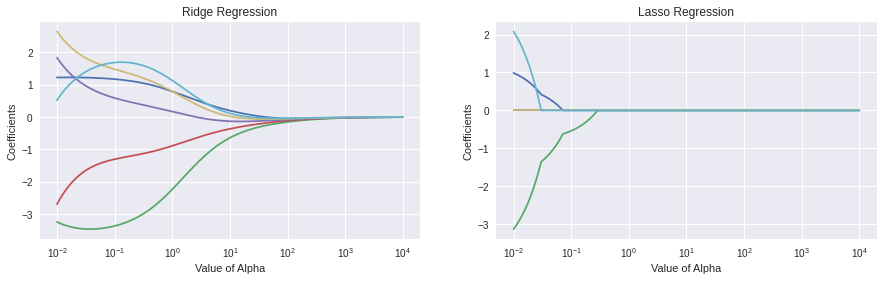

In [17]:
# Weights spectrum: change the alpha parameter gradually (on a logartithmic scale) and observe how the coefficients change for
# degrees=5 over alpha for Ridge and Lasso.

n_alphas = 1000
alphas = np.logspace(-2, 4, n_alphas)
n_samples =100

deg = 5
models = ['Ridge Regression', 'Lasso Regression']
#get values of error and coef at different Alpha

# Generate data and perform 5 degrees polynomial features transform
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1
trans = PolynomialFeatures(degree=deg)
Xpoly = trans.fit_transform(X[:, np.newaxis])

coefs = np.zeros((len(models),n_alphas,deg+1))

for i,a in enumerate(alphas):
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(Xpoly, y)
    coefs[0,i,:] = ridge.coef_
    lasso = Lasso(alpha=a, fit_intercept=False)
    lasso.fit(Xpoly, y)
    coefs[1,i,:] = lasso.coef_

#plot graphs
fig, axes = plt.subplots(1,2, figsize=(15,4),sharey=True,  gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
for i in range(len(models)):
    ax = plt.subplot(1,2,i+1)
    ax.plot(alphas, coefs[i,:,:])
    plt.title(models[i])
    ax.set_xscale('log')
    plt.xlabel('Value of Alpha')
    plt.ylabel('Coefficients')
    plt.axis('tight')
plt.show()


**What is the take home message?** 

Alpha is a parameter which balances the amount of emphasis given to minimizing RSS vs minimizing size of coefficients. The higher the alpha, the lower the values of coefficients needed for minimizing the loss function. I.E as alpha is higher the model gives less influence to changes in the features value for target predictions. Although this solves the problem of overfitting, large values of alpha (strong restriction and penalties) make the model unable to catch the cosinus relation of the data anymore.

Importantly, there is a difference between the two regularization methods: while Lasso regulariztion tends to cut off  factors by turning their coefficients to zero, Ridge regularization tends to shrinking these coefficients to a tiny number (none zero), keep some of their influence on Y (and therfore the coefficients values "decay" more slowly). Moreover, since Lasso penalize the the summation of the absolute value (first order) of coefficients, its available area is squared, which reflects in steep descents for Lasso as compared to more smooth descents in Ridge (where the restriction is on the summation of the second order of coefficients and a circular available area).